<a href="https://colab.research.google.com/github/tanyatibouche/Screw-Project2/blob/main/test_amelia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unrar x screw_dataset.rar screw_dataset/

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, F1Score
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img, ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

print("Using TensorFlow version:", tf.__version__)

# Pour reproduire un comportement stable (optionnel)
tf.random.set_seed(42)

Using TensorFlow version: 2.18.0


In [ ]:
# Configuration
DATA_DIR = "./screw_dataset/screw_dataset2"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

# Fonctions de transformation
def rotate_image(image, angle_degrees):
    return tf.image.rot90(
        image,
        k=int(round(angle_degrees / 90)) % 4
    )

def specialized_augmentation(image):
    """
    Augmentations simulant des défauts réels
    """
    transforms = [
        # Simulation de rayures
        lambda img: tf.image.adjust_contrast(img, random.uniform(1.5, 2.5)),

        # Variations de géométrie du filetage
        lambda img: rotate_image(img, random.choice([-10, 10])),

        # Simulation d'imperfections de surface
        lambda img: tf.image.random_brightness(img, max_delta=0.2),

        # Variations de texture
        lambda img: tf.image.adjust_saturation(img, random.uniform(0.5, 2.0))
    ]

    # Combiner aléatoirement les transformations
    selected_transforms = random.sample(transforms, random.randint(1, 2))

    transformed = image
    for transform in selected_transforms:
        transformed = transform(transformed)

    return tf.clip_by_value(transformed, 0.0, 1.0)

# Focal Loss pour gérer le déséquilibre des classes
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return focal_loss_fixed

# Fonction de data augmentation
def data_augmentation(X_train, y_train, BATCH_SIZE=32):
    # Trouver les indices des images "bad" et "good"
    bad_indices = np.where(y_train[:, 0] == 0)[0]
    good_indices = np.where(y_train[:, 0] == 1)[0]

    X_bad = X_train[bad_indices]
    X_good = X_train[good_indices]

    print(f"Nombre d'images 'bad' avant augmentation: {len(X_bad)}")
    print(f"Nombre d'images 'good' avant augmentation: {len(X_good)}")

    # Générer des images augmentées
    X_bad_augmented = []
    y_bad_augmented = []

    # Générer des augmentations jusqu'à atteindre le nombre d'images 'good'
    np.random.seed(42)
    remaining_count = len(X_good)

    while len(X_bad_augmented) < remaining_count:
        # Choisir une image source
        img_source = X_bad[len(X_bad_augmented) % len(X_bad)]

        # Appliquer la transformation
        transformed_img = specialized_augmentation(img_source)

        # Ajouter l'image
        X_bad_augmented.append(transformed_img.numpy())
        y_bad_augmented.append(0)

    # Convertir en arrays numpy
    X_bad_augmented = np.array(X_bad_augmented)
    y_bad_augmented = np.array(y_bad_augmented).reshape(-1, 1)

    # Combiner avec les images "good"
    X_train_balanced = np.concatenate([X_good, X_bad_augmented])
    y_train_balanced = np.concatenate([
        y_train[good_indices],
        y_bad_augmented
    ])

    # Mélanger le nouvel ensemble d'entraînement
    indices = np.arange(len(X_train_balanced))
    np.random.shuffle(indices)
    X_train_balanced = X_train_balanced[indices]
    y_train_balanced = y_train_balanced[indices]

    # Créer un nouveau dataset TensorFlow
    train_dataset_balanced = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
    train_dataset_balanced = train_dataset_balanced.shuffle(buffer_size=len(X_train_balanced)).batch(BATCH_SIZE)
    return X_train_balanced, y_train_balanced, train_dataset_balanced
    print()

In [ ]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'),F1Score(name='f1_score')]  # Métriques
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,972,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,977,185 (22.80 MB)

 Trainable params: 5,977,185 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1,
    mode='min' )
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'mon_cnn.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

history = model.fit(
    train_dataset_balanced,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, reduce_lr]
    )

NameError: name 'train_dataset_balanced' is not defined

In [ ]:
val_loss, val_accuracy, val_recall, val_f1_score = model.evaluate(val_dataset, verbose=0)

print(f"Loss sur la validation : {val_loss:.4f}")
print(f"Accuracy sur la validation : {val_accuracy:.4f}")
print(f"Recall sur la validation : {val_recall:.4f}")
print(f"F1-Score sur la validation : {val_f1_score:.4f}")

Loss sur la validation : 1.4792
Accuracy sur la validation : 0.4319
Recall sur la validation : 1.0000
F1-Score sur la validation : 0.6032


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step


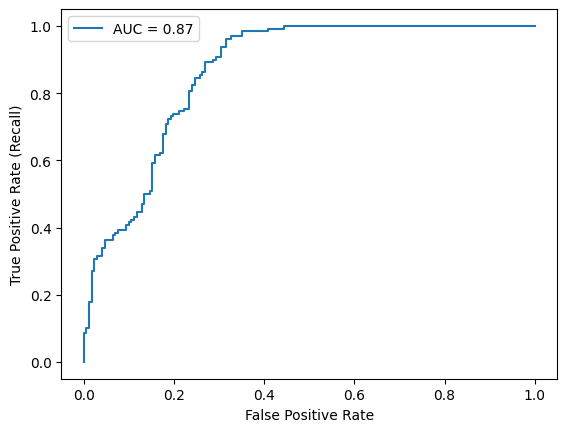

In [ ]:
y_proba = model.predict(val_dataset).ravel()  # Utilisez .ravel() au lieu de [:,1]
y_true = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

fpr, tpr, thresholds = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc(fpr, tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

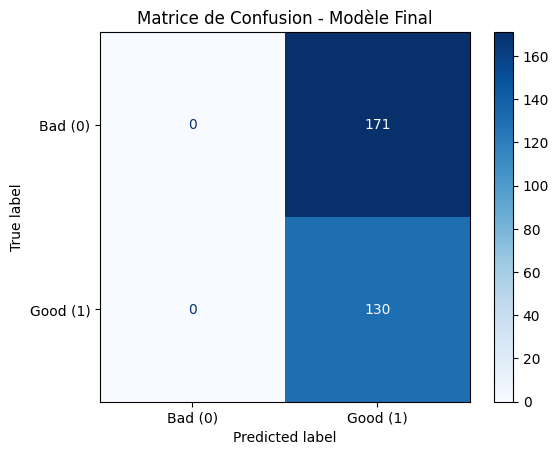

\nRapport de Classification :
              precision    recall  f1-score   support

     Bad (0)       0.00      0.00      0.00       171
    Good (1)       0.43      1.00      0.60       130

    accuracy                           0.43       301
   macro avg       0.22      0.50      0.30       301
weighted avg       0.19      0.43      0.26       301



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur l'ensemble de validation
y_pred = (y_proba > 0.5).astype(int)  # Seuil à 0.5 pour la classification binaire

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Calcul et affichage de la matrice
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad (0)', 'Good (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion - Modèle Final')
plt.show()

# Optionnel : Rapport de classification détaillé
from sklearn.metrics import classification_report
print("\\nRapport de Classification :")
print(classification_report(y_true, y_pred, target_names=['Bad (0)', 'Good (1)']))